In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
import math
import nltk
import re
from sklearn import feature_extraction
import random
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from wordcloud import WordCloud
from collections import Counter

## Looking into data

In [2]:
df = pd.read_csv('./boston/reviews.csv')
df_listing = pd.read_csv('./boston/listings.csv')

In [3]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [4]:
df_listing.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN


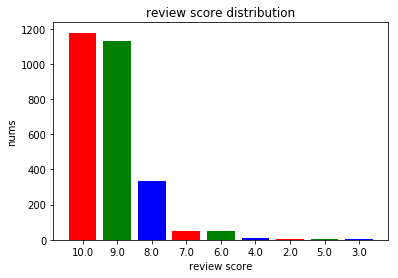

In [6]:
# review score distribution
score_count = df_listing.review_scores_value.value_counts()
name_list = list(score_count.axes[0])
num_list = score_count.values
plt.bar(range(len(num_list)), num_list,color='rgb',tick_label=name_list)
plt.title('review score distribution')
plt.xlabel('review score')
plt.ylabel('nums')
plt.show()

most people trend to give high score

## process comment

In [7]:
document = df['comments'].dropna()

In [8]:
document.shape[0]

68222

In [9]:
stopwords = nltk.corpus.stopwords.words('english')

In [10]:
def tokenize(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [27]:
entities = [] 
neg_entity_pair = [] # negative word pare
pos_entity_pair = [] # positive word pare
sid = SentimentIntensityAnalyzer()
for doc in document:
    try:
        allwords_stemmed = tokenize(doc) 
        pos_tags = nltk.pos_tag(allwords_stemmed)
        pre_tag = ''
        pre_word = ''
        for word,pos in pos_tags:
            if 'NN' in pos and 'JJ' in pre_tag:
                word_pair = pre_word + ' ' + word
                postive_score = sid.polarity_scores(pre_word)['pos']
                neg_score = sid.polarity_scores(pre_word)['neg']
                # socre is higher than 0.7 
                if postive_score > 0.7:
                    entities.append(word)
                    pos_entity_pair.append(word_pair)
                if neg_score > 0.7:
                    entities.append(word)
                    neg_entity_pair.append(word_pair)
            pre_tag = pos
            pre_word = word
    except Exception as e:
        print(e)
        print(doc)

In [29]:
entities_c = Counter(entities)
entities_c.most_common(10)

[('host', 9932),
 ('location', 9496),
 ('place', 6733),
 ('stay', 5306),
 ('experience', 4260),
 ('i', 3506),
 ('time', 3107),
 ('neighborhood', 2405),
 ('apartment', 2405),
 ('hosts', 2317)]

In [34]:
pos_entity_pare_c = Counter(pos_entity_pair)
pos_entity_pare_c.most_common(10)

[('great location', 5078),
 ('great host', 3779),
 ('great place', 2402),
 ('great stay', 1989),
 ('great experience', 1714),
 ('great time', 1631),
 ('easy access', 1186),
 ('perfect location', 1155),
 ('wonderful host', 956),
 ('good location', 876)]

In [35]:
# remove some too common and useless word
remove_list = ['location', 'hosts', 'host', 'place', 'stay', 'experience','i','apartment']
pos_entity_process = []
neg_entity_process = []
def remove_nonsene(data,remove_list):
    result = []
    for item in data:
        match = False
        for word in remove_list:
            if word in item:
                match = True
                break
        if not match:
            result.append(item)
    return result
pos_entity_process = remove_nonsene(pos_entity_pair,remove_list)
neg_entity_process = remove_nonsene(neg_entity_pair,remove_list)
entities_process = remove_nonsene(entities,remove_list)

In [65]:
pos_entity_c = Counter(pos_entity_process)
pos_entity_c.most_common(30)

[('easy access', 1186),
 ('great restaurants', 745),
 ('comfortable bed', 710),
 ('easy walk', 478),
 ('good restaurants', 365),
 ('great value', 314),
 ('clean room', 287),
 ('great spot', 282),
 ('great area', 271),
 ('good value', 259),
 ('super clean', 247),
 ('warm welcome', 216),
 ('best part', 216),
 ('top floor', 208),
 ('clean towels', 207),
 ('super comfy', 198),
 ('comfortable room', 197),
 ('great job', 195),
 ('comfortable beds', 194),
 ('perfect spot', 183),
 ('lovely home', 183),
 ('great food', 181),
 ('fresh towels', 174),
 ('super helpful', 166),
 ('great space', 165),
 ('great room', 153),
 ('clean cozy', 134),
 ('safe area', 131),
 ('good food', 122),
 ('easy check', 119)]

## create wordcloud

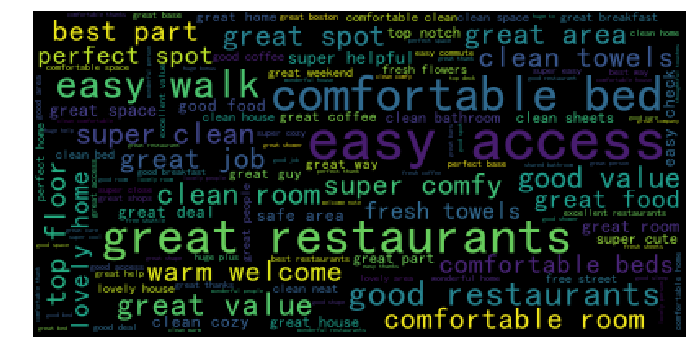

In [51]:
wordcloud=WordCloud(font_path="simhei.ttf",max_font_size=40)
wordcloud=wordcloud.fit_words(pos_entity_c)
plt.figure(figsize=(12, 6))
plt.axis('off')
plt.imshow(wordcloud)

In [39]:
# ramdom show one comment that mention the input words
def show_comment(item):
    for doc in document:
        rand_val = random.random()*10
        if item in doc and rand_val > 7:
            print(doc)
            break    

In [64]:
show_comment('warm welcome')

Tom was very accommodating to my request at the last minute. Very warm welcome and covered all details on how to navigate the apartment and building and made a obvious effort to make me comfortable during my short stay. He even let me borrow his Charlie Card! 
